# Simulation Optimization
1. Vairance Reduction:
  - antithetic variates method.
  - control variates.
  - importance sampling. 

2. MCMC Simulation
3. QMC Simulaiton


We are using 2015-01-01 - 2017-12-31 as training set, and simulate the data for the next entire year 2018-01-01 - 2018-12-31.

In [37]:
# %pip install emcee

In [58]:

import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import norm, lognorm
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.integrate import quad

# JPM - Example - Define for each optimization
---

## Plotting the Training data period and simulated data period

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'JPM Stock Price from 2015-01-01 to 2018-12-31')

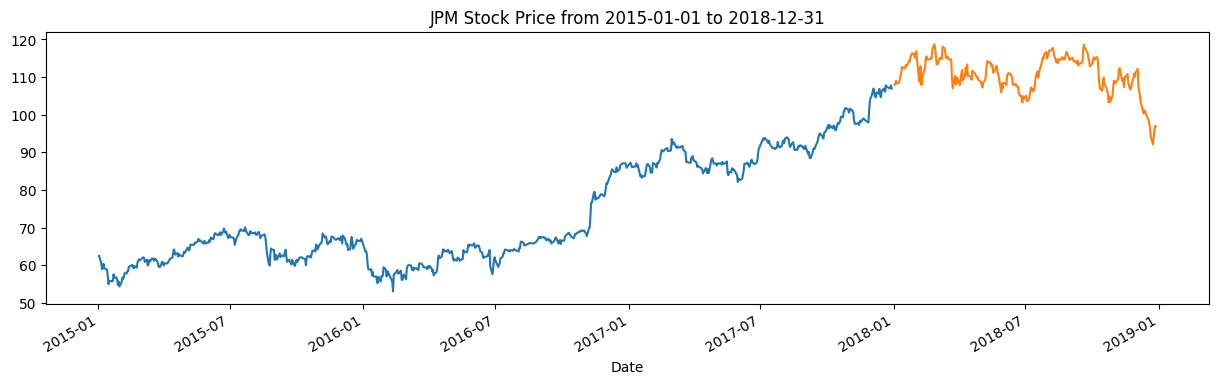

In [59]:

stock_data = yf.download('JPM', '2015-01-01','2017-12-31', interval="1d")  # download data from Yahoo Finance
stock_data = stock_data['Close']
stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return
stock_data.plot(figsize=(10,4))  # Stock price plot
stock_data = yf.download('JPM', '2018-01-01','2018-12-31', interval="1d")  # download data from Yahoo Finance
stock_data = stock_data['Close']
stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return

stock_data.plot(figsize=(15,4))  # Stock price plot
plt.title('JPM'+' Stock Price from '+ '2015-01-01' + ' to ' + '2018-12-31')

### Optimization Strategy-1: antithetic variates method

In [60]:
def Monte_carlo_pre_var_reduction(stock_name, start_date, end_date):
    stock_data = yf.download(stock_name, start_date, end_date, interval="1d")  # download data from Yahoo Finance
    stock_data = stock_data['Close']
    stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return
    
    u = stock_log_returns.mean()  # Calculate drift
    var = stock_log_returns.var()
    drift = u - (0.5*var)
    stddev = stock_log_returns.std()
    
    t_intervals = 365  # simulation param
    iterations = 1000
    
    # Generate two sets of random variables for each time interval
    daily_returns1 = np.exp(drift + stddev * norm.ppf(np.random.rand(t_intervals,iterations//2)))
    daily_returns2 = np.exp(drift + stddev * norm.ppf(np.random.rand(t_intervals,iterations//2)))
    daily_returns = np.concatenate((daily_returns1, -daily_returns2), axis=1)  # Combine the two sets with opposite signs
    
    price_list = np.zeros_like(daily_returns)  # Calculate stock prices
    price_list[0] = S0 = stock_data[-1]

    for t in range(1,t_intervals):
        price_list[t] = price_list[t-1]*daily_returns[t]

    # Calculate evaluation metrics MAE and MSE
    actual_prices = yf.download(stock_name, "2018-01-01", "2018-12-31", interval="1d")
    actual_prices = actual_prices['Close']

    predicted_prices = price_list[-1][:len(actual_prices)]
    print(len(predicted_prices))
    mae = np.mean(np.abs(predicted_prices - actual_prices))
    mse = np.mean((predicted_prices - actual_prices)**2)
    print('MAE: ', mae)
    print('MSE: ', mse)
        
    plt.figure(figsize=(15,4))  # 10 of predicted prices plot
    plt.plot(pd.DataFrame(price_list).iloc[:,0:100])
    plt.title(stock_name+' Monte Carlo Prediction')
    plt.show()
    
    plt.figure(figsize=(15,4))  # predicted price range in 't_interval' days
    plt.hist(pd.DataFrame(price_list).iloc[-1],bins=30)
    plt.title(stock_name+' Price Prediction in 252 days')
    plt.xlabel("Price after 365 days")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  38.30139929636446
MSE:  2479.0869291442227


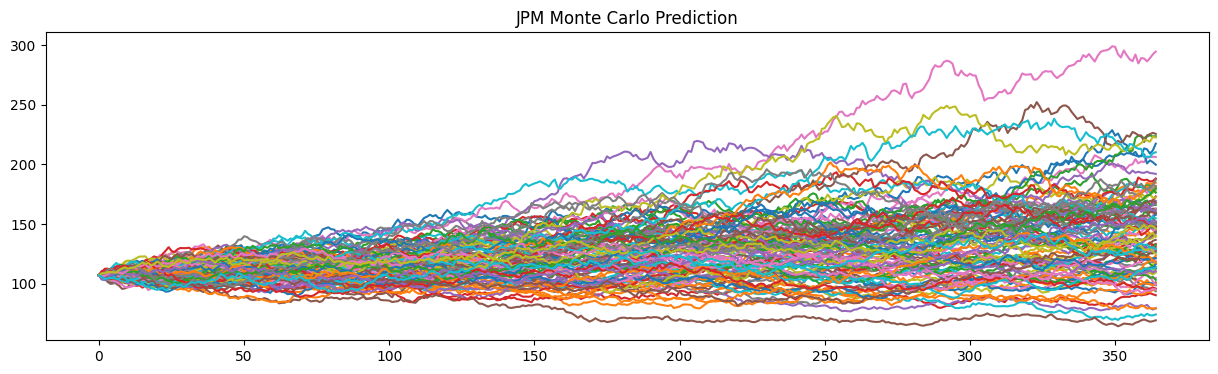

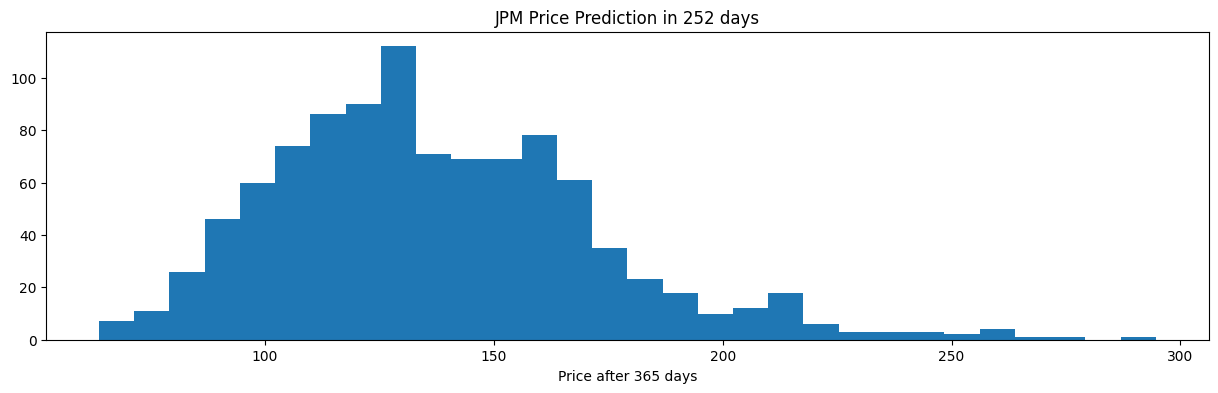

In [61]:
Monte_carlo_pre_var_reduction('JPM','2015-01-01','2017-12-31')

### Optimization Strategy-2: control variates

In [62]:
def Monte_carlo_pre_var_reduction2(stock_name, start_date, end_date):
    stock_data = yf.download(stock_name, start_date, end_date, interval="1d")  # download data from Yahoo Finance
    stock_data = stock_data['Close']
    stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return

    # Define a control variate: S&P 500 index
    index_data = yf.download("^GSPC", start_date, end_date, interval="1d")
    index_data = index_data['Close']
    index_log_returns = np.log(1+index_data.pct_change())
    
    u = stock_log_returns.mean()  # Calculate drift
    var = stock_log_returns.var()
    drift = u - (0.5*var)
    stddev = stock_log_returns.std()
    
    # Calculate the correlation coefficient between stock log returns and index log returns
    corr = np.corrcoef(stock_log_returns.dropna(), index_log_returns.dropna())[0,1]
    
    t = 252  # simulation param
    dt = 1/t
    iterations = 1000
    
    # Generate random variables for each time interval
    daily_returns = np.exp(drift*dt + stddev * np.sqrt(dt) * norm.ppf(np.random.rand(t,iterations)))
    
    # Calculate the price of the related security (S&P 500 index) for each time interval
    index_prices = np.zeros_like(daily_returns)
    index_prices[0] = index_data[-1]
    for i in range(1, t):
        index_prices[i] = index_prices[i-1]*np.exp(index_log_returns.sample().iloc[0])
    
    # Calculate the stock prices using the daily returns and the related security prices as a control variate
    stock_prices = np.zeros_like(daily_returns)
    stock_prices[0] = S0 = stock_data[-1]
    for i in range(1, t):
        Y = daily_returns[i]
        X = index_prices[i]
        b = np.cov(stock_log_returns.dropna(), index_log_returns.dropna())[0,1] / index_log_returns.var()
        Y_hat = stock_prices[i-1]*np.exp((drift-b)*dt)
        stock_prices[i] = Y + b*(X-Y_hat)
    
    actual_prices = yf.download(stock_name, "2018-01-01", "2018-12-31", interval="1d")
    actual_prices = actual_prices['Close']
    
    predicted_prices = stock_prices[-1][:len(actual_prices)]
    print(len(predicted_prices))
    mae = np.mean(np.abs(predicted_prices - actual_prices))
    mse = np.mean((predicted_prices - actual_prices)**2)
    print('MAE: ', mae)
    print('MSE: ', mse)
        

    plt.figure(figsize=(15,4))  # 10 of predicted prices plot
    plt.plot(pd.DataFrame(stock_prices).iloc[:,0:10])
    plt.title(stock_name+' Monte Carlo Prediction')
    plt.show()
    
    plt.figure(figsize=(15,4))  # predicted price range in 't' days
    plt.hist(pd.DataFrame(stock_prices).iloc[-1],bins=30)
    plt.title(stock_name+' Price Prediction in 365 days')
    plt.xlabel("Price after 365 days")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  2.931870515820597e+33
MSE:  8.595864721542412e+66


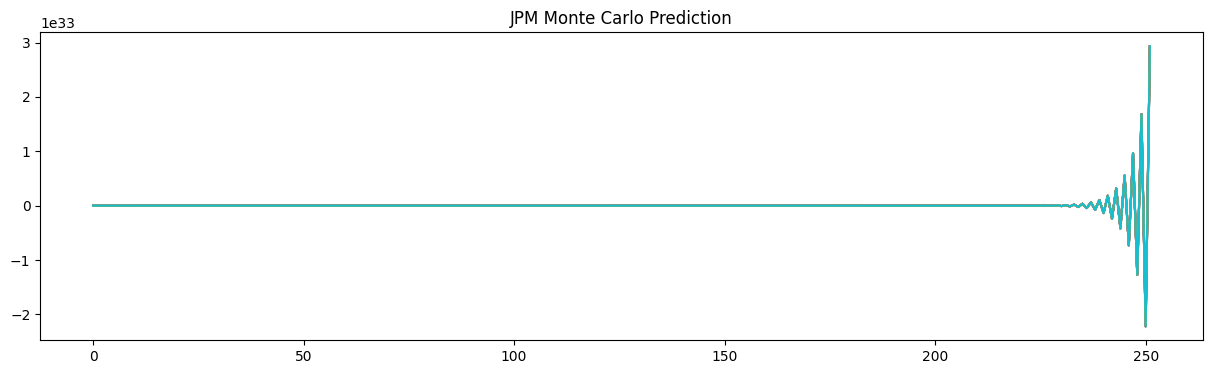

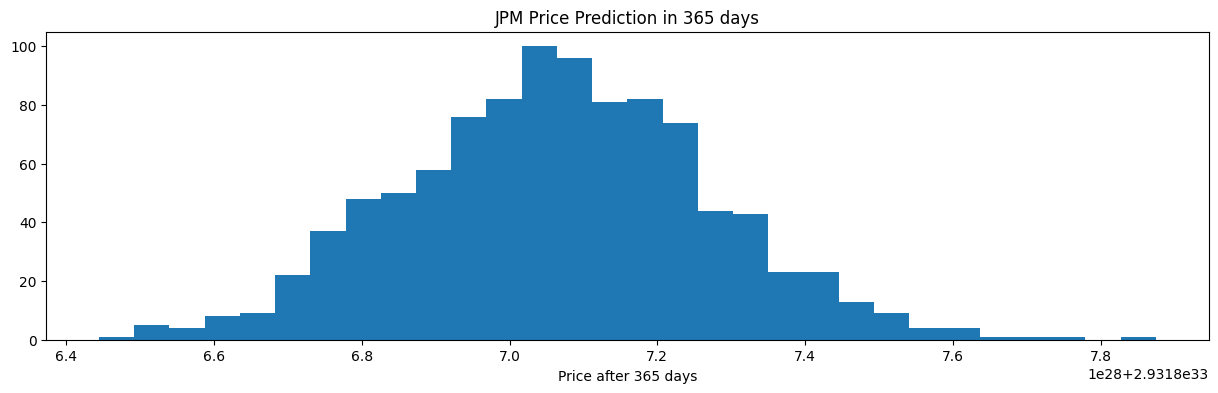

In [64]:
Monte_carlo_pre_var_reduction2('JPM','2015-01-01','2017-12-31')

### Optimization Strategy-3: importance sampling

In [65]:

def Monte_carlo_pre_var_reduction3(stock_name, start_date, end_date):
    stock_data = yf.download(stock_name, start_date, end_date, interval="1d")  # download data from Yahoo Finance
    stock_data = stock_data['Close']
    stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return
    
    u = stock_log_returns.mean()  # Calculate drift
    var = stock_log_returns.var()
    drift = u - (0.5*var)
    stddev = stock_log_returns.std()
    
    # Define a log-normal distribution with parameters based on the stock log returns
    mu = stock_log_returns.mean()
    sigma = stock_log_returns.std()
    dist = lognorm(s=sigma, scale=np.exp(mu))

    t_intervals = 252  # simulation param
    iterations = 1000
    
    # Generate random variables from the log-normal distribution using importance sampling
    Z = dist.rvs(size=(t_intervals, iterations))
    daily_returns = np.exp(drift + stddev * Z) / dist.pdf(Z)
    
    stock_prices = np.zeros_like(daily_returns)  # Calculate stock prices
    stock_prices[0] = S0 = stock_data[-1]
    for t in range(1,t_intervals):
        stock_prices[t] = stock_prices[t-1]*daily_returns[t]
    
    actual_prices = yf.download(stock_name, "2018-01-01", "2018-12-31", interval="1d")
    actual_prices = actual_prices['Close']
    
    predicted_prices = stock_prices[-1][:len(actual_prices)]
    print(len(predicted_prices))
    mae = np.mean(np.abs(predicted_prices - actual_prices))
    mse = np.mean((predicted_prices - actual_prices)**2)
    print('MAE: ', mae)
    print('MSE: ', mse)

    plt.figure(figsize=(15,4))  
    plt.plot(pd.DataFrame(stock_prices).iloc[:,0:100])
    plt.title(stock_name+' Monte Carlo Prediction')
    plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  110.77575991821288
MSE:  12294.237402864555


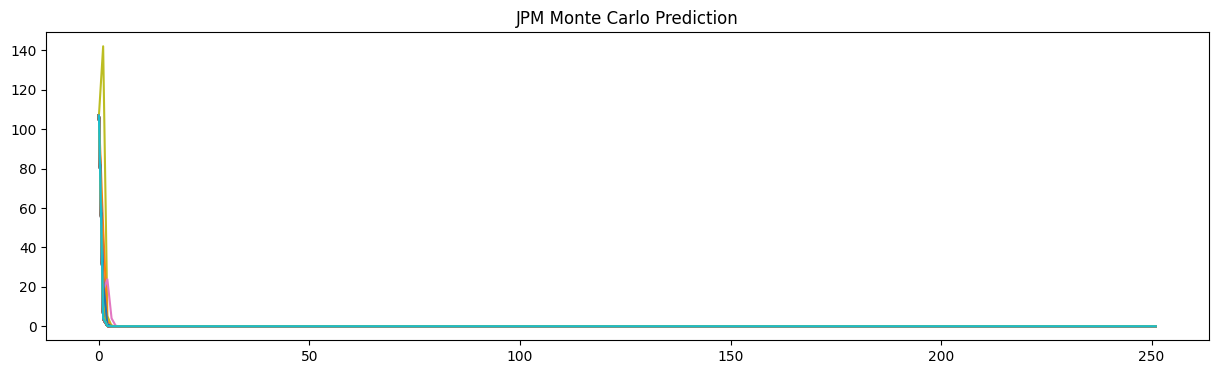

In [66]:
Monte_carlo_pre_var_reduction3('JPM','2015-01-01','2017-12-31')

### Optimization - 4: MCMC Simulation

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  46.96611988830566
MSE:  2253.454878643404


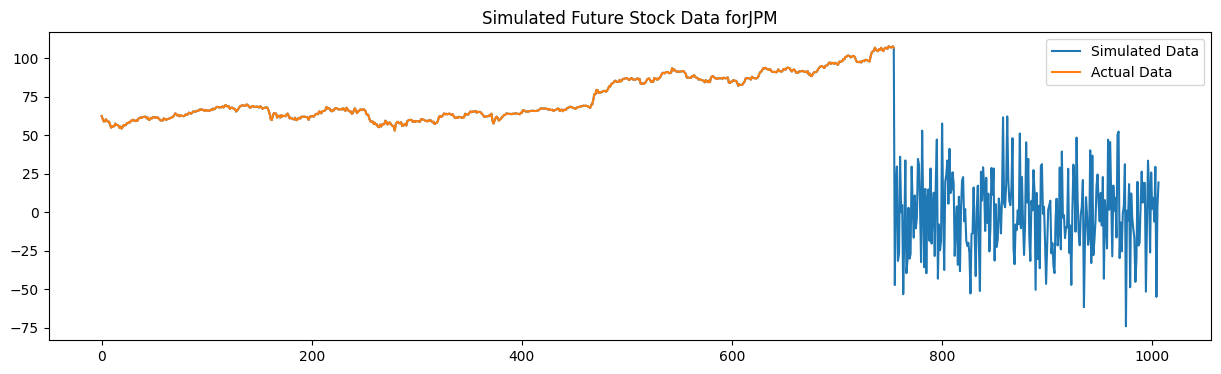

In [67]:
# Download stock data from Yahoo Finance
def MCMC(stock_name, start_date, end_date):
    def download_stock_data(stock_name, start_date, end_date):
        stock_data = yf.download(stock_name, start_date, end_date, interval="1d")
        stock_data = stock_data['Close']
        return stock_data

    # Define log likelihood function for the model
    def log_likelihood(theta, x, t, y):
        mu, sigma = theta
        model = mu * x + t
        sigma = abs(sigma)
        return -0.5 * np.sum((y - model) ** 2 / sigma ** 2 + np.log(2 * np.pi * sigma ** 2))

    # Define log prior function for the model
    def log_prior(theta):
        mu, sigma = theta
        if 0 < sigma < 1000:
            return -np.log(sigma)
        return -np.inf

    # Define log posterior function for the model
    def log_posterior(theta, x, t, y):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, t, y)

    # Define function to run the MCMC simulation
    def run_mcmc(stock_data):
        n_dim, n_walkers = 2, 100
        n_burn, n_steps = 500, 1000

        # Initialize the walkers
        pos = [np.array([np.random.uniform(-1, 1), np.random.uniform(0, 1)]) for i in range(n_walkers)]

        # Define the sampler
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=(np.arange(len(stock_data)), 0, stock_data))

        # Run the burn-in phase
        pos, _, _ = sampler.run_mcmc(pos, n_burn)

        # Run the production phase
        sampler.reset()
        sampler.run_mcmc(pos, n_steps)

        # Extract the samples
        samples = sampler.flatchain[:, :]
        return samples

    # Define function to simulate future data using the MCMC samples
    def simulate_future_data(stock_data, samples, n_years=1):
        n = len(stock_data)
        mu_samples, sigma_samples = samples[:, 0], samples[:, 1]
        future_data = np.zeros(n + 252 * n_years)
        future_data[:n] = stock_data

        for i in range(n, n + 252 * n_years):
            idx = i - n
            x = idx / 252
            mu = np.mean(mu_samples)
            sigma = np.mean(sigma_samples)
            y = np.random.normal(mu * x, abs(sigma))
            future_data[i] = y

        return future_data


    stock_data = download_stock_data(stock_name, start_date, end_date)
    samples = run_mcmc(stock_data)
    future_data = simulate_future_data(stock_data, samples, n_years=1)
    
    actual_prices = yf.download(stock_name, "2018-01-01", "2018-12-31", interval="1d")
    actual_prices = actual_prices['Close']
    
    predicted_prices = future_data[:len(actual_prices)]
    print(len(predicted_prices))
    mae = np.mean(np.abs(predicted_prices - actual_prices))
    mse = np.mean((predicted_prices - actual_prices)**2)
    print('MAE: ', mae)
    print('MSE: ', mse)
    # Plot the future data
    plt.figure(figsize=(15,4)) 
    plt.plot(np.arange(len(future_data)), future_data, label='Simulated Data')
    plt.plot(np.arange(len(stock_data)), stock_data, label='Actual Data')
    plt.title('Simulated Future Stock Data for' + stock_name)
    plt.legend()
    plt.show()

MCMC('JPM', '2015-01-01', '2017-12-31')

### Optimizaiton Strategy - 4: Quasi-MC Simulation

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  18.56293965747668
MSE:  558.6813337220466


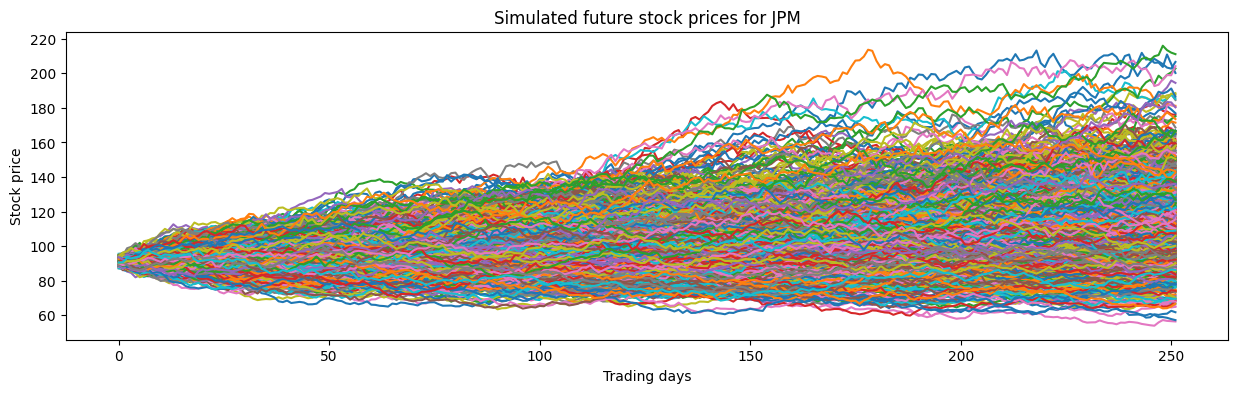

In [68]:
def QMC(stock_name, start, end):
    # Retrieve historical stock prices
    symbol = stock_name
    start_date = start
    end_date = end
    data = yf.download(symbol, start=start_date, end=end_date)['Adj Close']

    # Calculate daily returns
    returns = data.pct_change().dropna()

    # Compute the mean and standard deviation of the daily returns
    mu = np.mean(returns)
    sigma = np.std(returns)

    # Define the function to calculate future stock prices
    def simulate_stock_price(start_price, mu, sigma, n_days, n_simulations):
        sobol_samples = np.zeros((n_days, n_simulations))
        for i in range(n_simulations):
            sobol_samples[:, i] = np.array([np.random.uniform(0, 1, size=n_days)])
        norminv = norm.ppf(sobol_samples)
        daily_returns = np.exp((mu - 0.5 * sigma**2) * np.ones((n_days, n_simulations)) + sigma * norminv)
        price = start_price * daily_returns.cumprod(axis=0)
        return price

    # Set the start price to be the most recent close price
    start_price = data[-1]

    # Simulate future prices for the next 1 year (252 trading days)
    n_days = 252
    n_simulations = 1000
    simulated_prices = simulate_stock_price(start_price, mu, sigma, n_days, n_simulations)

    actual_prices = yf.download('JPM', "2018-01-01", "2018-12-31", interval="1d")
    actual_prices = actual_prices['Close']
        
    predicted_prices = simulated_prices[-1][:len(actual_prices)]
    print(len(predicted_prices))
    mae = np.mean(np.abs(predicted_prices - actual_prices))
    mse = np.mean((predicted_prices - actual_prices)**2)
    print('MAE: ', mae)
    print('MSE: ', mse)


    # Plot the simulated prices
    plt.figure(figsize=(15,4)) 
    plt.plot(simulated_prices)
    plt.xlabel('Trading days')
    plt.ylabel('Stock price')
    plt.title(f'Simulated future stock prices for {symbol}')
    plt.show()

QMC('JPM', '2015-01-01', '2017-12-31')

[*********************100%***********************]  1 of 1 completed


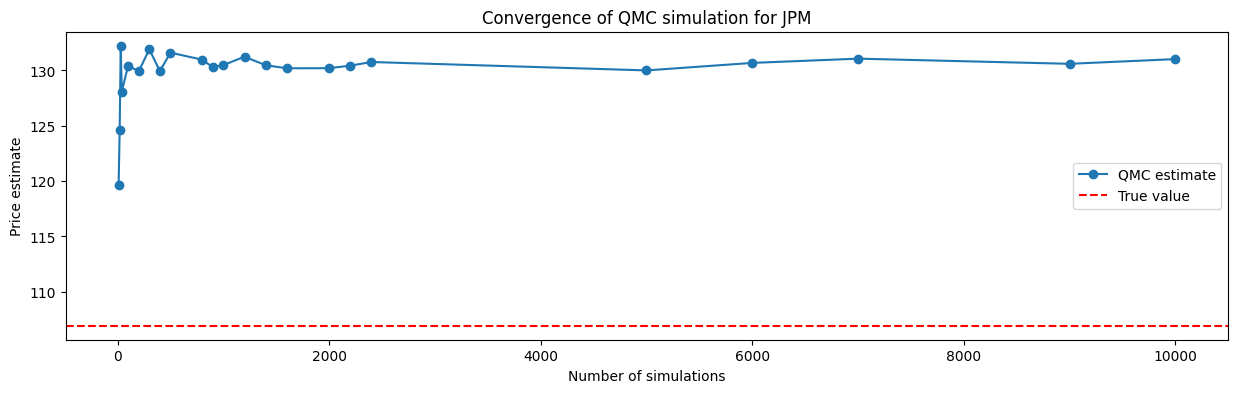

In [69]:
# Retrieve historical stock prices
def QMC_converge(stock_name, s, e):
    symbol = stock_name
    start_date = s
    end_date = e
    data = yf.download(symbol, start=start_date, end=end_date)['Close']
    n_days = 252
    # Calculate daily returns
    returns = data.pct_change().dropna()

    # Compute the mean and standard deviation of the daily returns
    mu = np.mean(returns)
    sigma = np.std(returns)

    # Define the function to calculate future stock prices
    def simulate_stock_price(start_price, mu, sigma, n_days, n_simulations):
        sobol_samples = np.zeros((n_days, n_simulations))
        for i in range(n_simulations):
            sobol_samples[:, i] = np.array([np.random.uniform(0, 1, size=n_days)])
        norminv = norm.ppf(sobol_samples)
        daily_returns = np.exp((mu - 0.5 * sigma**2) * np.ones((n_days, n_simulations)) + sigma * norminv)
        price = start_price * daily_returns.cumprod(axis=0)
        return price

    # Set the start price to be the most recent close price
    start_price = data[-1]

    # Run the simulation with increasing number of simulations
    n_simulations_list = [10, 20, 30, 40, 100, 200, 300, 400, 500, 800, 900, 1000, 1200, 1400, 1600, 2000, 2200, 2400, 5000, 6000, 7000, 9000, 10000]
    mean_list = []
    error_list = []
    for n_simulations in n_simulations_list:
        simulated_prices = simulate_stock_price(start_price, mu, sigma, n_days, n_simulations)
        mean = np.mean(simulated_prices[-1, :])
        error = np.abs(data[-1] - mean)
        mean_list.append(mean)
        error_list.append(error)

    # Plot the estimates against the number of simulations
    plt.figure(figsize=(15,4))
    plt.plot(n_simulations_list, mean_list, '-o', label='QMC estimate')
    plt.axhline(y=data[-1], color='r', linestyle='--', label='True value')
    plt.xlabel('Number of simulations')
    plt.ylabel('Price estimate')
    plt.title(f'Convergence of QMC simulation for {symbol}')
    plt.legend()
    plt.show()

QMC_converge('JPM', '2015-01-01', '2017-12-31')

# BOA Banck of American
---

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'BAC Stock Price from 2015-01-01 to 2018-12-31')

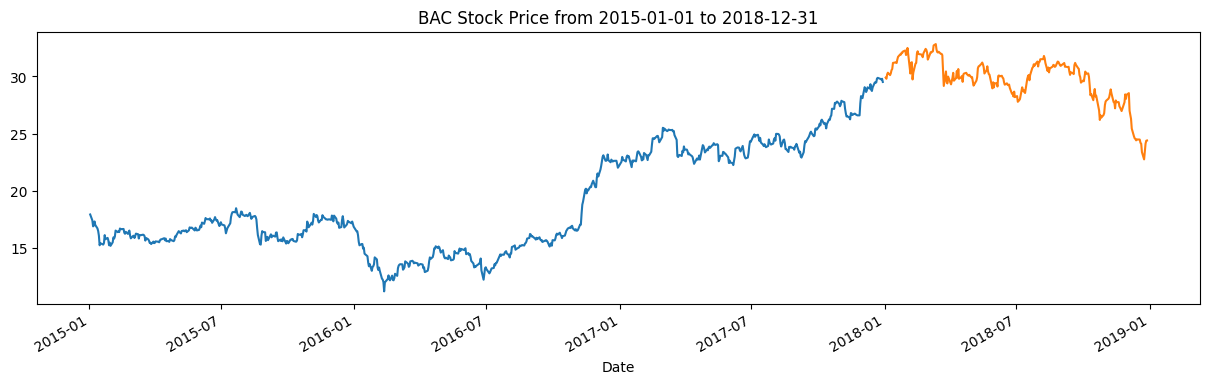

In [70]:

stock_data = yf.download('BAC', '2015-01-01','2017-12-31', interval="1d")  # download data from Yahoo Finance
stock_data = stock_data['Close']
stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return
stock_data.plot(figsize=(10,4))  # Stock price plot
stock_data = yf.download('BAC', '2018-01-01','2018-12-31', interval="1d")  # download data from Yahoo Finance
stock_data = stock_data['Close']
stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return

stock_data.plot(figsize=(15,4))  # Stock price plot
plt.title('BAC'+' Stock Price from '+ '2015-01-01' + ' to ' + '2018-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  9.923042171487687
MSE:  169.54124399512287


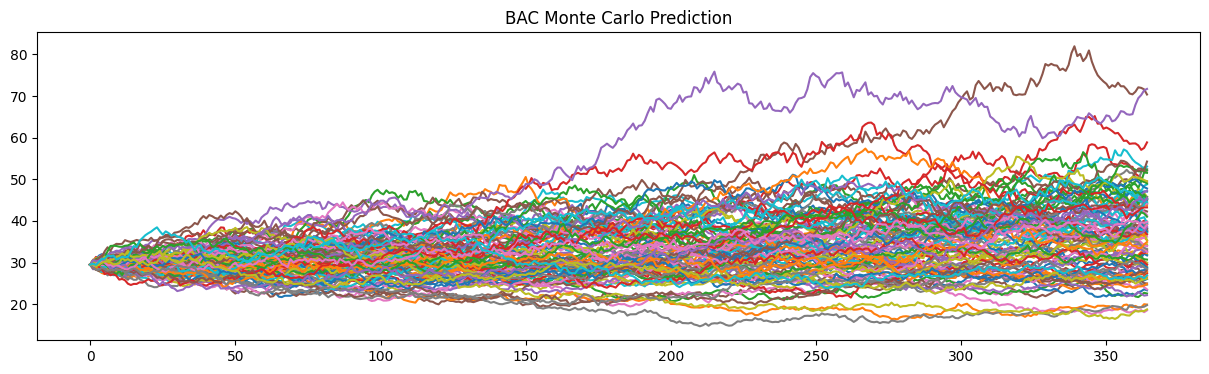

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  3.0386493239299114e+47
MSE:  9.233389713823163e+94


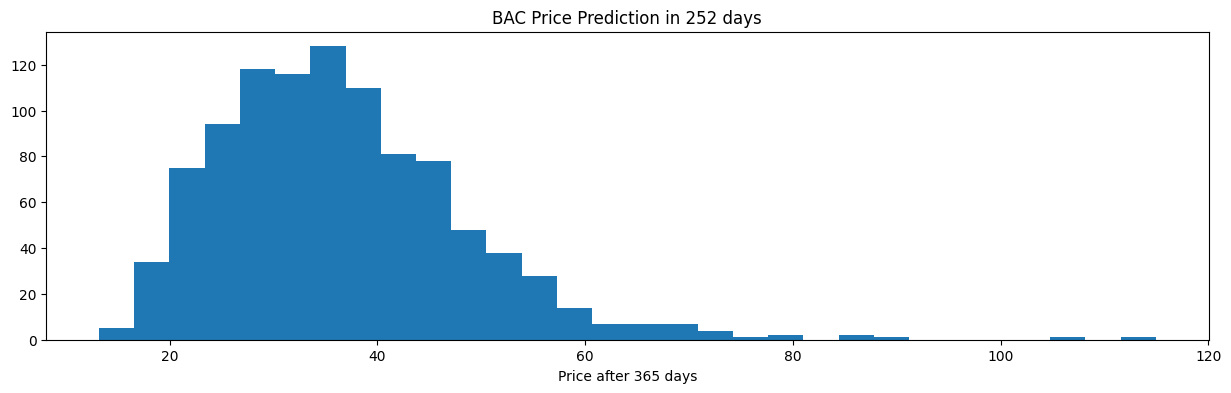

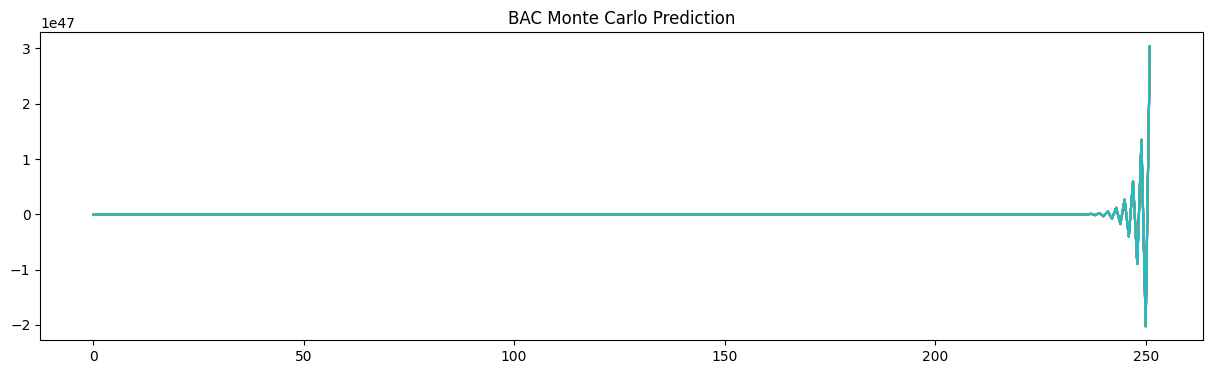

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  29.715279983520507
MSE:  886.9057709086308


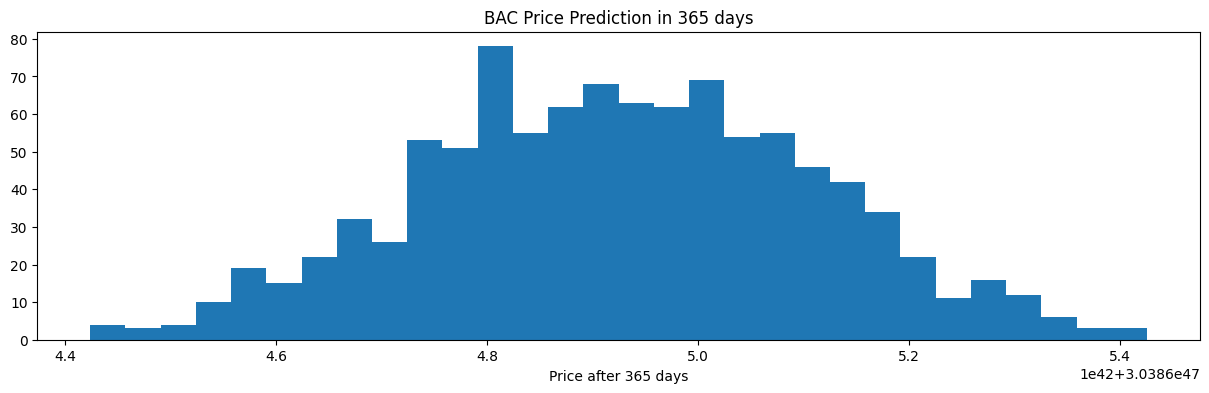

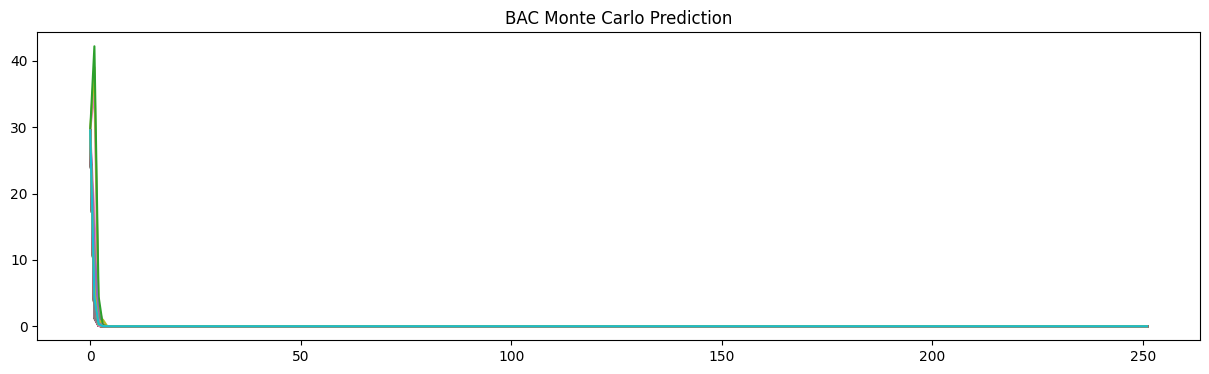

In [71]:
Monte_carlo_pre_var_reduction('BAC','2015-01-01','2017-12-31')
Monte_carlo_pre_var_reduction2('BAC','2015-01-01','2017-12-31')
Monte_carlo_pre_var_reduction3('BAC','2015-01-01','2017-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  13.142479919433594
MSE:  178.50879377760373


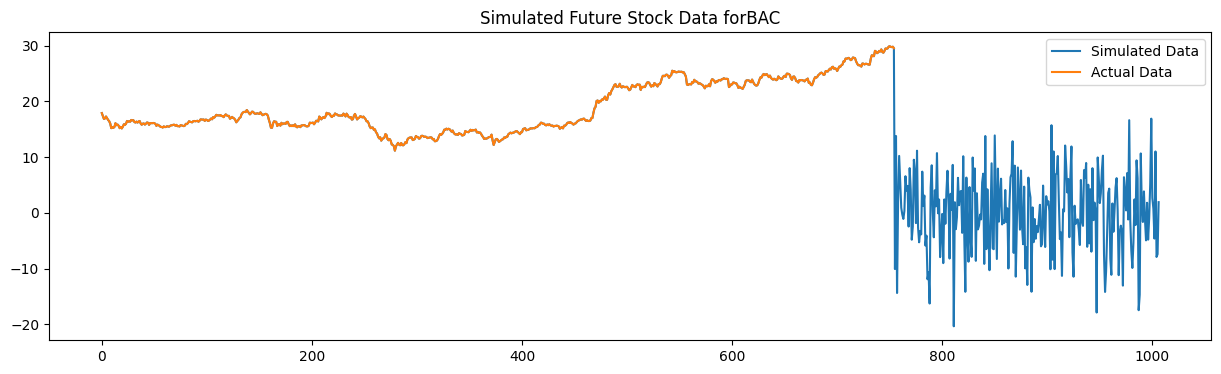

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  76.66728977560477
MSE:  5992.999368479095


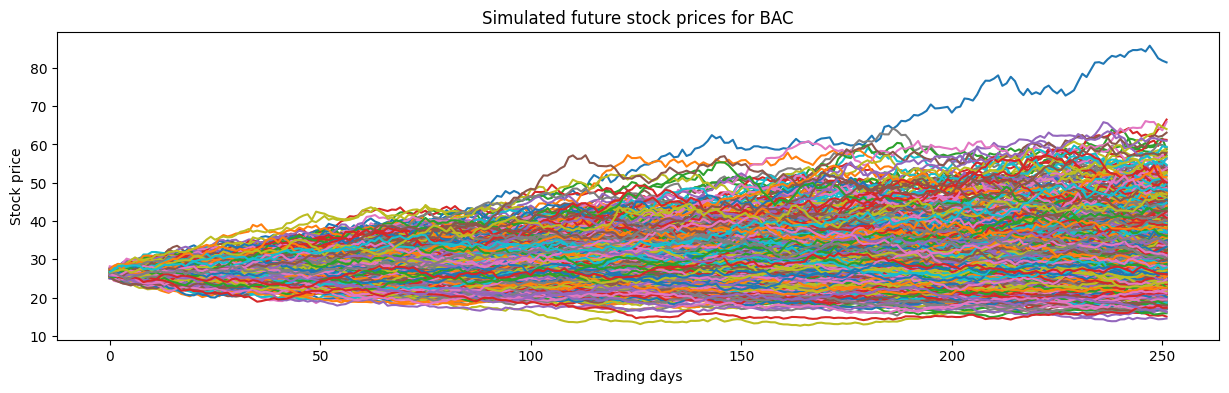

[*********************100%***********************]  1 of 1 completed


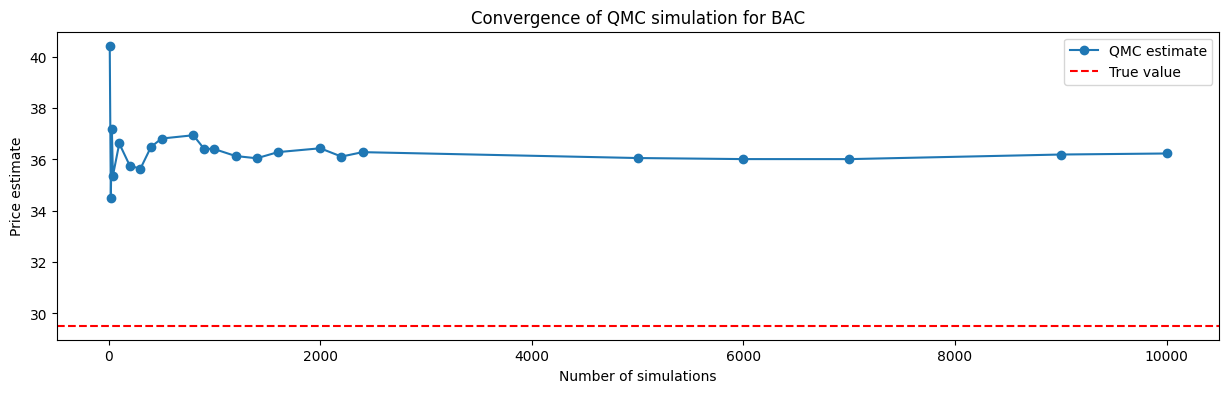

In [72]:
MCMC('BAC', '2015-01-01', '2017-12-31')
QMC('BAC', '2015-01-01', '2017-12-31')
QMC_converge('BAC', '2015-01-01', '2017-12-31')

# Wells Fargo 
---

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'WFC Stock Price from 2015-01-01 to 2018-12-31')

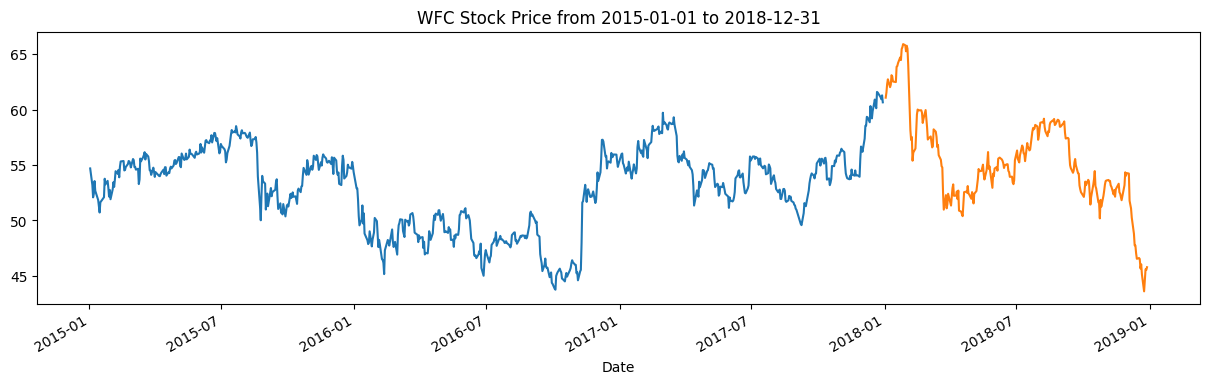

In [73]:

stock_data = yf.download('WFC', '2015-01-01','2017-12-31', interval="1d")  # download data from Yahoo Finance
stock_data = stock_data['Close']
stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return
stock_data.plot(figsize=(10,4))  # Stock price plot
stock_data = yf.download('WFC', '2018-01-01','2018-12-31', interval="1d")  # download data from Yahoo Finance
stock_data = stock_data['Close']
stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return

stock_data.plot(figsize=(15,4))  # Stock price plot
plt.title('WFC'+' Stock Price from '+ '2015-01-01' + ' to ' + '2018-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  15.01603737094928
MSE:  404.4046892504473


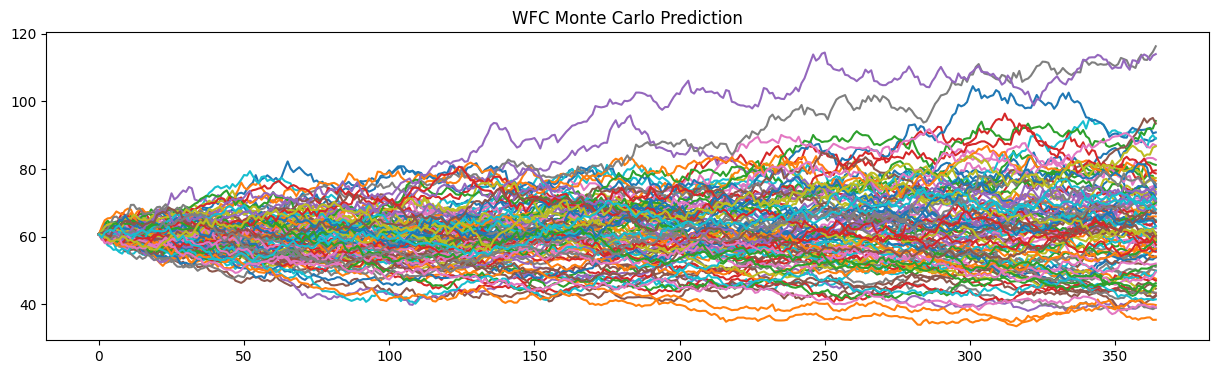

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  4.3747262879986693e+21
MSE:  1.9138230094920324e+43


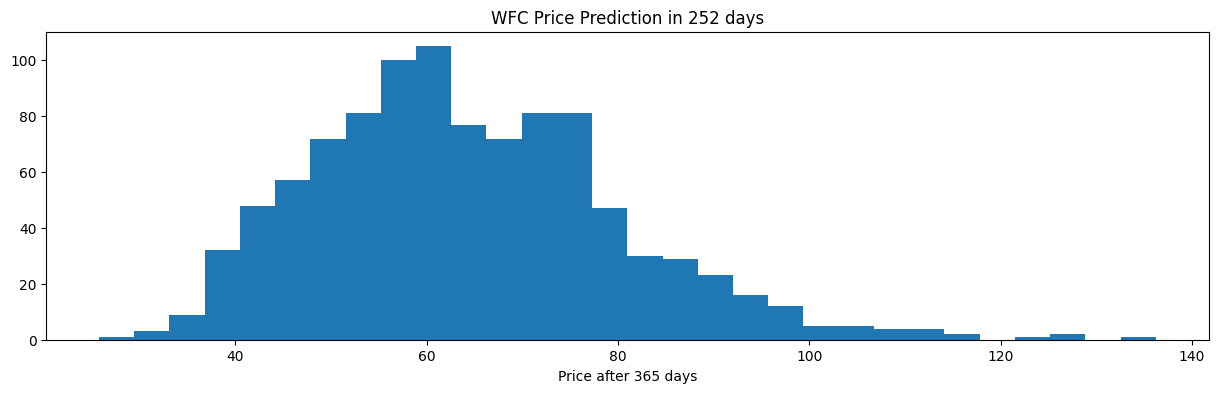

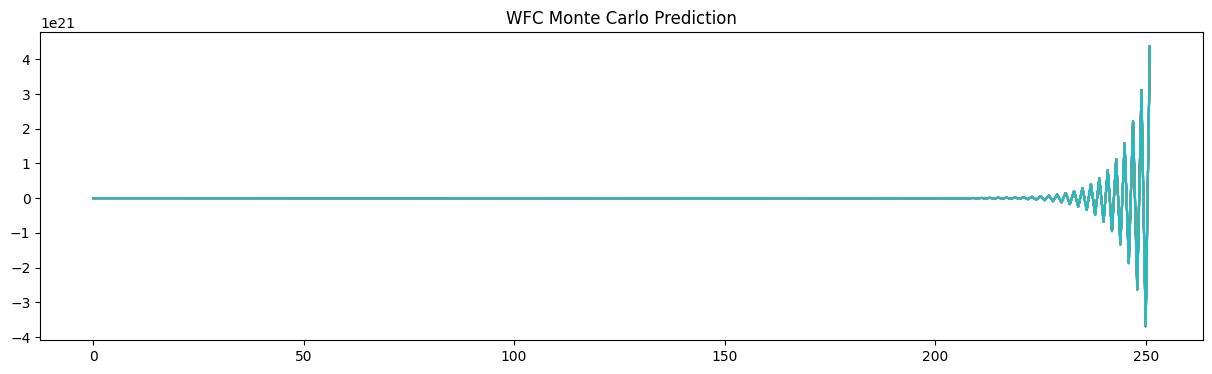

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  55.32072004699707
MSE:  3077.507892032753


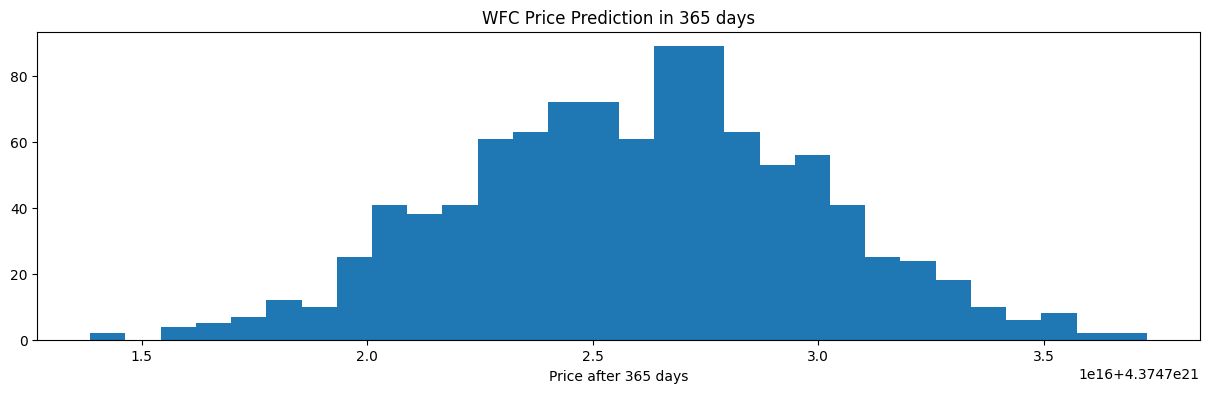

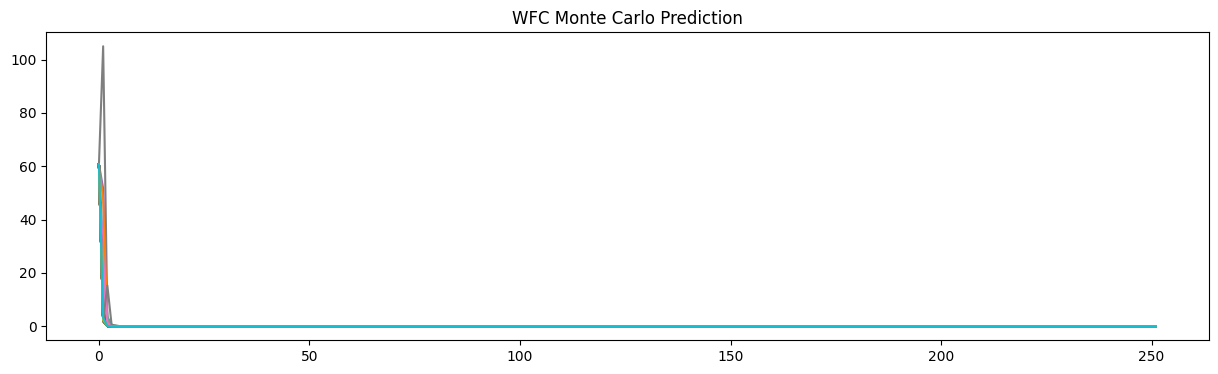

In [74]:
Monte_carlo_pre_var_reduction('WFC','2015-01-01','2017-12-31')
Monte_carlo_pre_var_reduction2('WFC','2015-01-01','2017-12-31')
Monte_carlo_pre_var_reduction3('WFC','2015-01-01','2017-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  3.520359878540039
MSE:  22.800069468215398


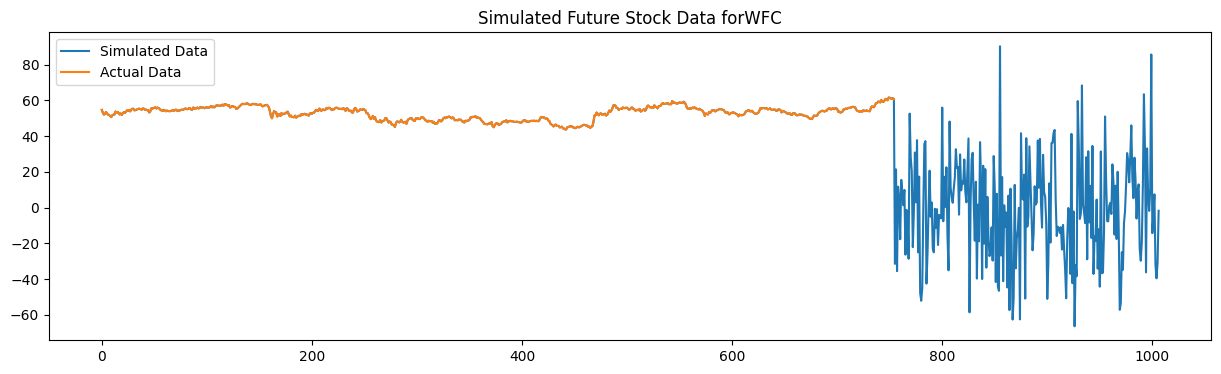

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  52.80460921126787
MSE:  2949.6641610294573


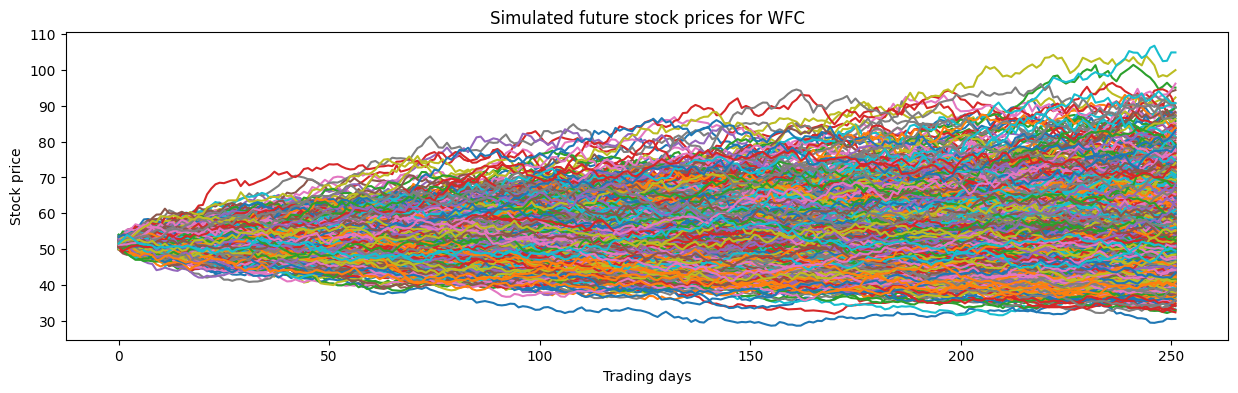

[*********************100%***********************]  1 of 1 completed


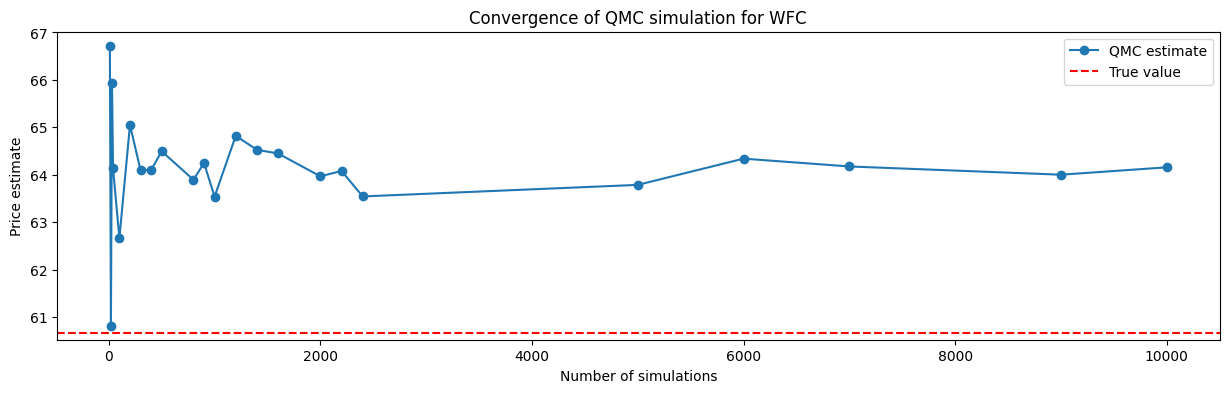

In [75]:
MCMC('WFC', '2015-01-01', '2017-12-31')
QMC('WFC', '2015-01-01', '2017-12-31')
QMC_converge('WFC', '2015-01-01', '2017-12-31')

# Citi

---

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'C Stock Price from 2015-01-01 to 2018-12-31')

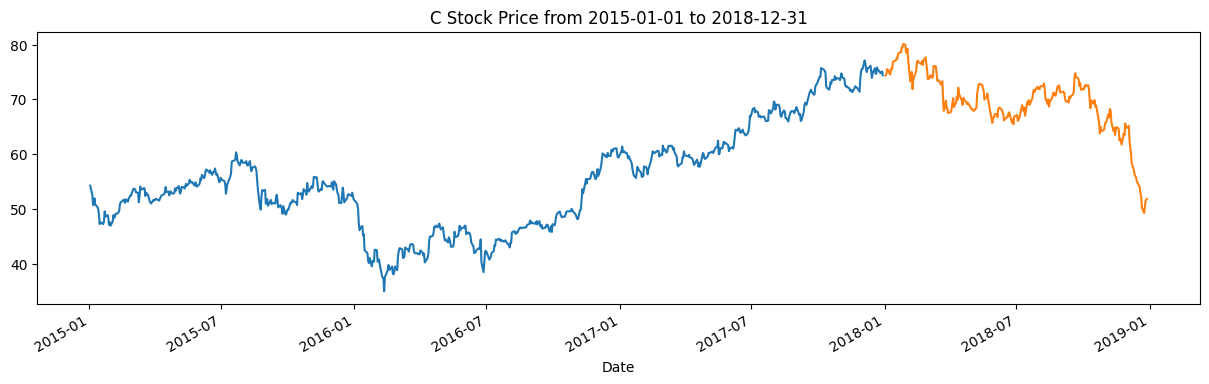

In [76]:

stock_data = yf.download('C', '2015-01-01','2017-12-31', interval="1d")  # download data from Yahoo Finance
stock_data = stock_data['Close']
stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return
stock_data.plot(figsize=(10,4))  # Stock price plot
stock_data = yf.download('C', '2018-01-01','2018-12-31', interval="1d")  # download data from Yahoo Finance
stock_data = stock_data['Close']
stock_log_returns = np.log(1+stock_data.pct_change())  # convert to log return

stock_data.plot(figsize=(15,4))  # Stock price plot
plt.title('C'+' Stock Price from '+ '2015-01-01' + ' to ' + '2018-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  22.49938818209487
MSE:  959.274241385123


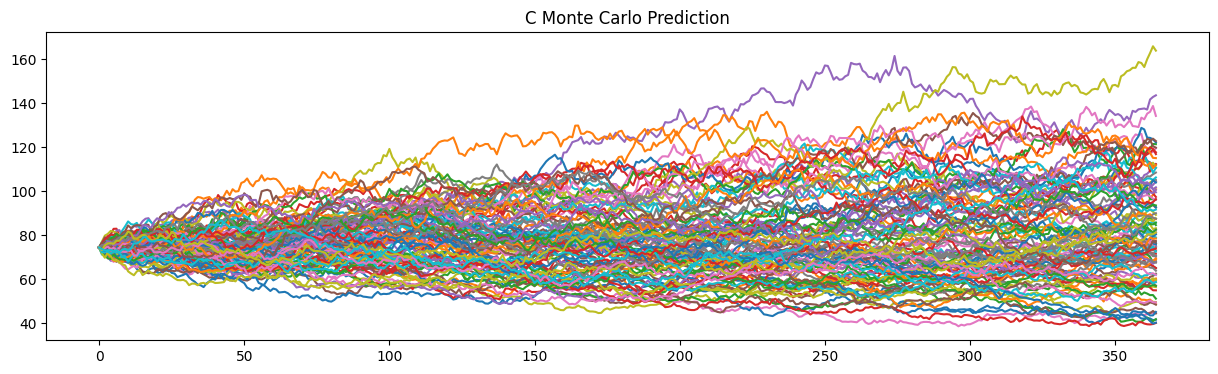

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  1.1568659702160813e+50
MSE:  1.3383388730444794e+100


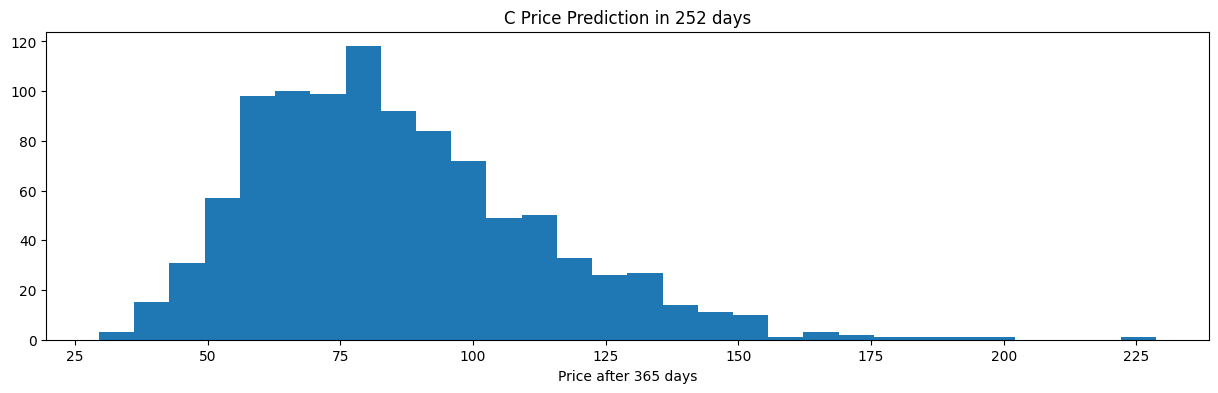

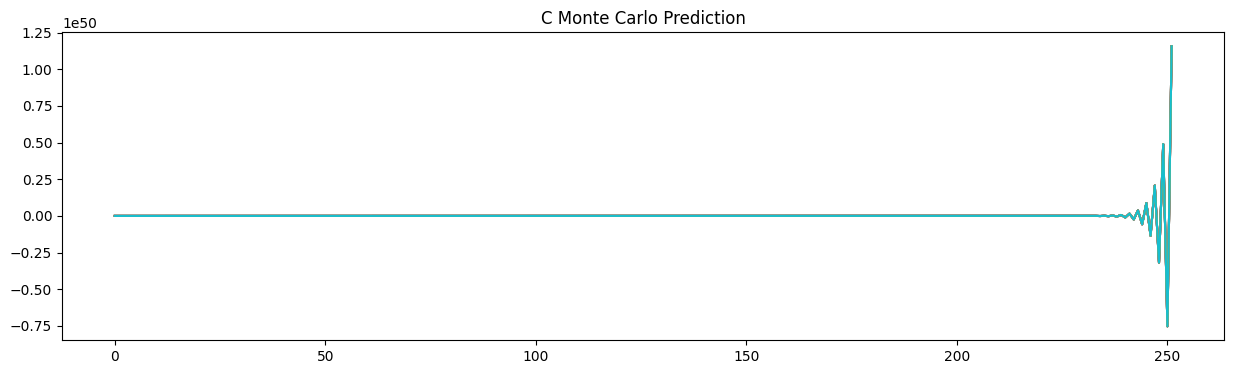

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  69.53011982727051
MSE:  4865.421474050651


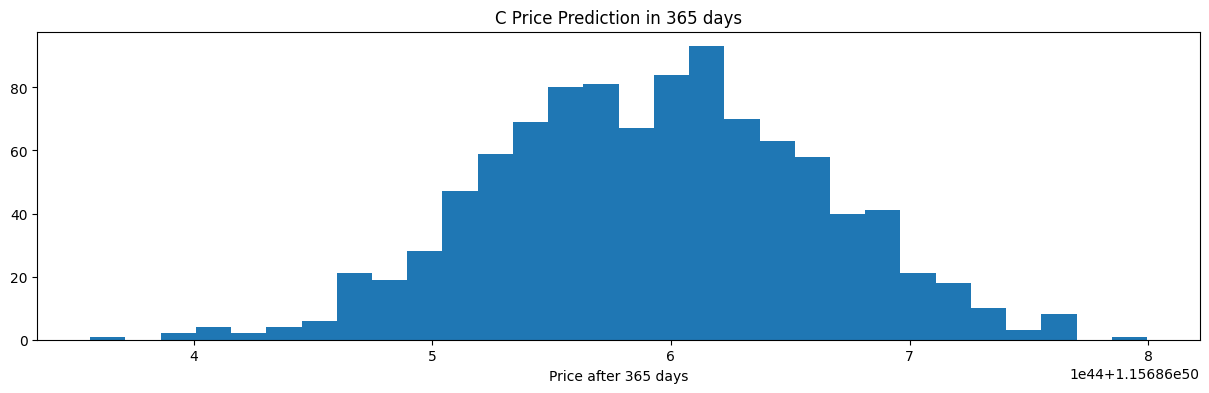

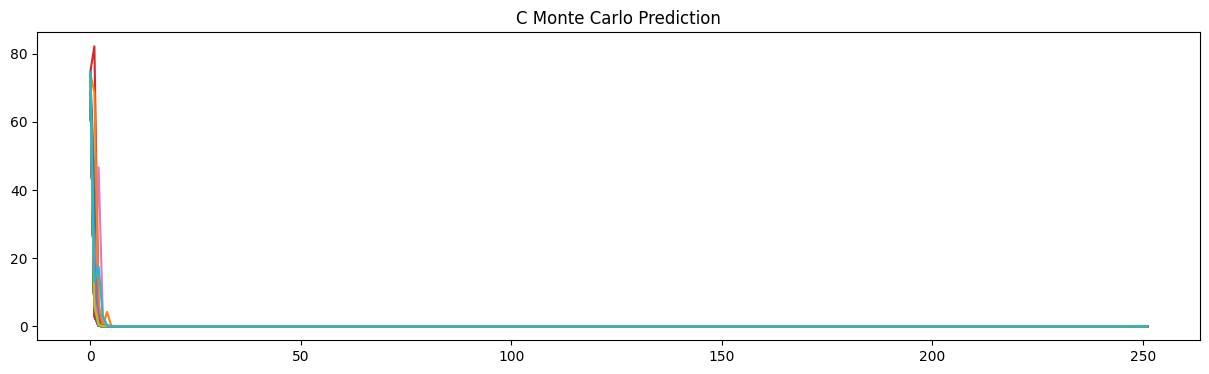

In [77]:
Monte_carlo_pre_var_reduction('C','2015-01-01','2017-12-31')
Monte_carlo_pre_var_reduction2('C','2015-01-01','2017-12-31')
Monte_carlo_pre_var_reduction3('C','2015-01-01','2017-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  16.30859977722168
MSE:  310.9468731260064


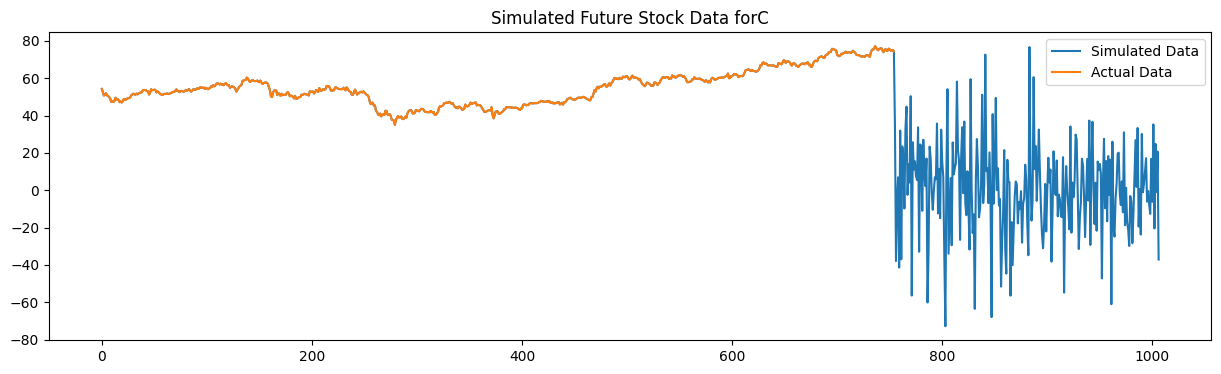

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
250
MAE:  38.035537929986646
MSE:  1773.7431383149535


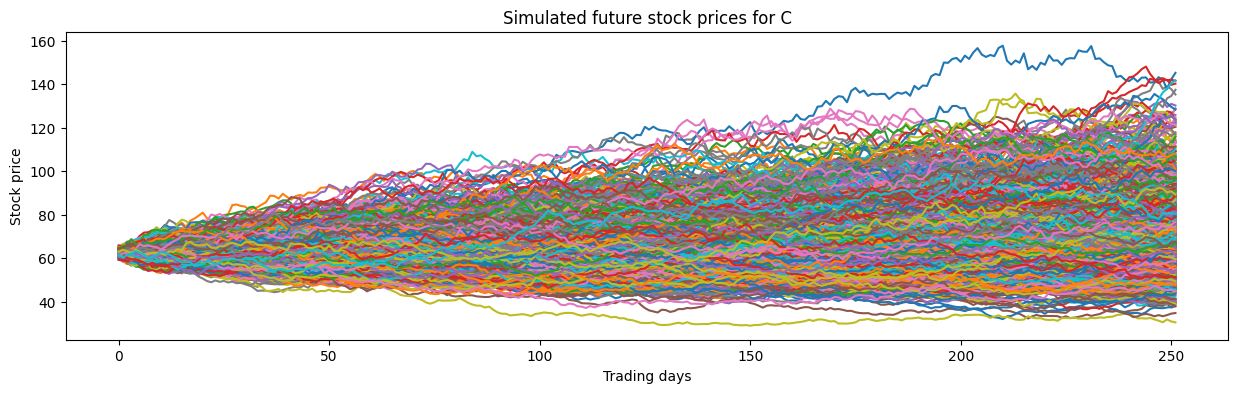

[*********************100%***********************]  1 of 1 completed


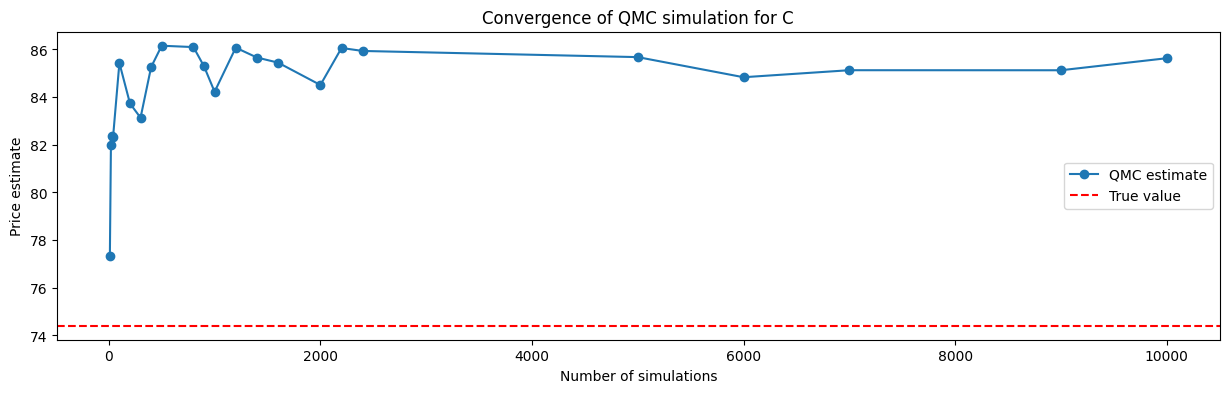

In [78]:
MCMC('C', '2015-01-01', '2017-12-31')
QMC('C', '2015-01-01', '2017-12-31')
QMC_converge('C', '2015-01-01', '2017-12-31')